# Preliminary data analysis and pre-processing

In [2]:
from __future__ import division, print_function
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from codes import cross_validate_classifier, \
                  format_classifier_performance, \
                  plot_confusion_matrix, metrics_wrapper

Import the data and specify the column names manually.

In [3]:
column_names = (
    [
    'Elevation',
    'Aspect_angle',
    'Slope',
    'Horiz_dist_to_nearest_water',
    'Vert_dist_to_nearest_water',
    'Horiz_dist_to_nearest_road',
    'Incident_sunlight_at_9am',
    'Incident_sunlight_at_12pm',
    'Incident_sunlight_at_3pm',
    'Horiz_dist_to_fire_ignition_point'    
    ]
    + ['Wilderness_area_{}'.format(i) for i in range(4)]
    + ['Soil_type_{}'.format(i) for i in range(40)]
    + ['Cover_type']
)

column_types = {
    name: np.float32 for name in column_names[:10]}.update(
    {name: np.int8 for name in column_names[10:]})

cover_types = [
    'Spruce/fir',
    'Lodgepole pine',
    'Ponderosa pine',
    'Cottonwood/willow',
    'Aspen',
    'Douglas-fir',
    'Krummholz'
]

data = pd.read_csv(join('data','covtype.data'), header=None, names=column_names, dtype=column_types)

In [4]:
data.head()

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point,...,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
descr = data[column_names[:10]].describe(percentiles=[0.1, 0.5, 0.9])
descr

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,2581.000000,24.000000,5.000000,30.000000,0.000000,591.000000,176.000000,198.000000,95.000000,595.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
90%,3272.000000,329.000000,24.000000,564.000000,121.000000,4793.000000,241.000000,247.000000,191.000000,3747.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


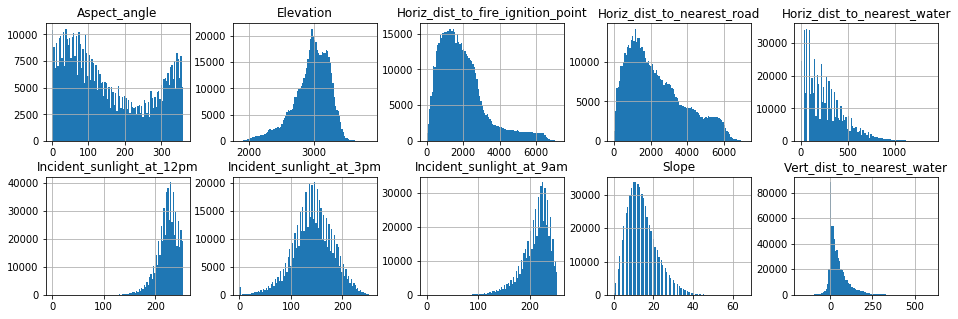

In [6]:
fig = plt.figure(figsize=(16, 5))
layout = (2, 5)
gs = GridSpec(*layout)
axes = [plt.subplot(gs[np.unravel_index(i, layout)]) for i in range(10)]
data[column_names[:10]].hist(bins=100, ax=axes)
plt.show()

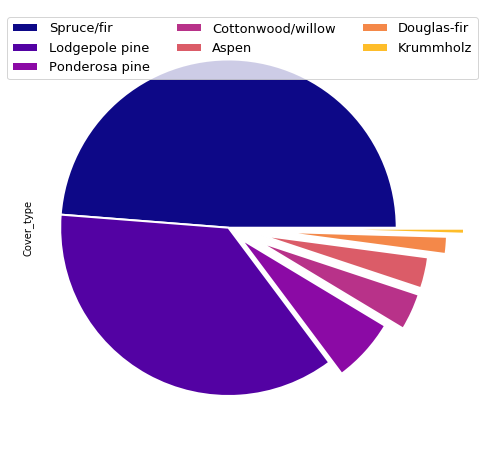

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_type, dtype: int64


In [7]:
cmap = plt.cm.get_cmap('plasma')
class_colours = np.array([cmap(i) for i in np.arange(7)/7])

fig = plt.figure(figsize=(8, 8))
data['Cover_type'].value_counts().plot(
    kind='pie', explode=(0, 0, 0.1, 0.2, 0.2, 0.3, 0.4),
    wedgeprops={'linewidth':2, 'edgecolor': 'w'}, labels=None,
    colors=class_colours, fontsize=16
)
plt.axis('equal')
plt.legend(labels=cover_types, fontsize=13, ncol=3)
plt.show()

print(data['Cover_type'].value_counts())

In [8]:
column_correlations = data[column_names[:10]].corr(method='pearson')

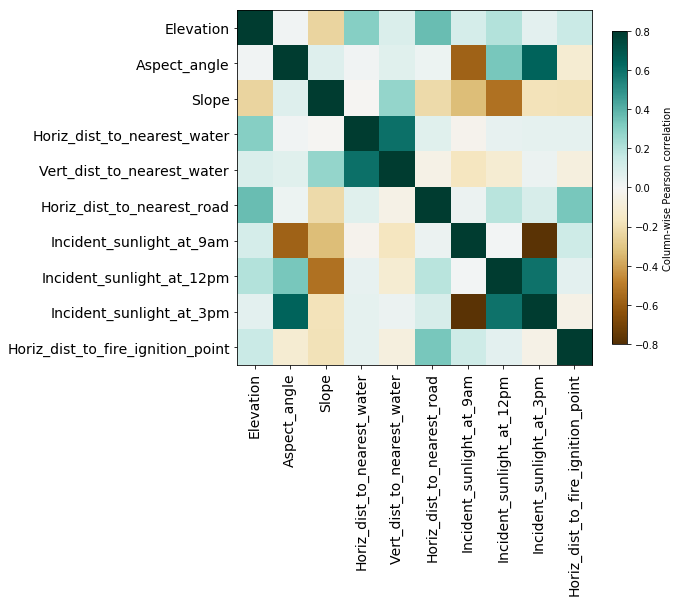

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(column_correlations, cmap=plt.cm.BrBG,
          vmin=-0.8, vmax=0.8, interpolation='nearest')
cbar = plt.colorbar(im, fraction=0.04)
cbar.set_label('Column-wise Pearson correlation')
ticks = np.arange(0, 10, 1); labels = np.array(column_names[:10])[ticks]
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xticklabels(labels, fontsize=14, rotation=90)

plt.show()

## Extract features and labels from dataframe

In [12]:
features = data[column_names[:14]].values
labels = data['Cover_type'].values - 1
print(features.shape, labels.shape)

(581012, 14) (581012,)


## How features separate classes

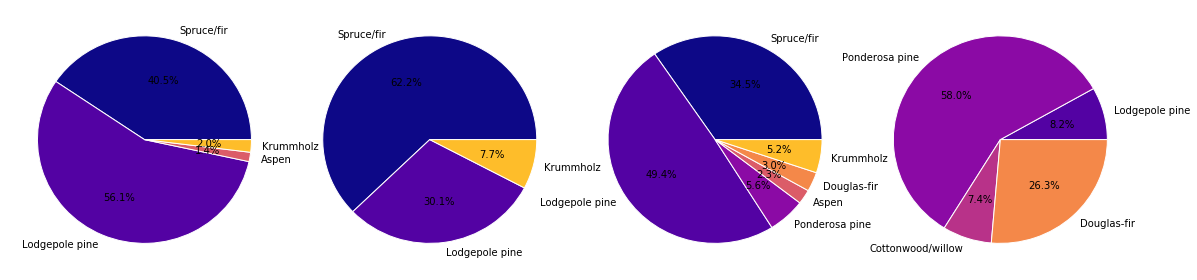

In [11]:
# Soil type and wilderness areas.
wilderness_columns = data[['Wilderness_area_{}'.format(i) for i in range(4)]].values.T
labels_per_area = [labels[np.where(w_col == 1)] for w_col in wilderness_columns]

fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4)

axes = [plt.subplot(gs[0, i]) for i in range(4)]


for i, ax in enumerate(axes):
    classes, class_counts = np.unique(labels_per_area[i], return_counts=True)
    ax.pie(class_counts, labels=np.array(cover_types)[classes], autopct='%1.1f%%',
        colors=class_colours[classes],
                 wedgeprops={'linewidth':1, 'edgecolor': 'w'})
    h, l = ax.get_legend_handles_labels()
plt.tight_layout()
plt.show()

In [17]:
feature_column = data['Elevation'].values

bins = 100

row_indices_split = np.array_split(feature_column.argsort(), bins)
binned_values = np.linspace(feature_column.min(), feature_column.max(), num=100)

(581012,)

## Outlier removal

In [35]:
# Remove data that lies outside 10-90% (or some other range)
numeric_data = data[column_names[:10]]
bool_array = (
    ( numeric_data > numeric_data.quantile(1e-4) )
    & ( numeric_data < numeric_data.quantile(1-1e-4) ).values
)
rows_to_keep = np.all(bool_array, axis=1)

In [36]:
print(bool_array.shape)
reduced_data = numeric_data.values[rows_to_keep, :]
print(reduced_data.shape) #542401, 10

(581012, 10)
(540300, 10)


In [41]:
print(features.shape, labels.shape)

#features = features[rows_to_keep]
#labels = labels[rows_to_keep]

print(features.shape, labels.shape)

(581012, 10) (581012,)
(581012, 10) (581012,)


## Make class representations equal in dataset

In [13]:
# re-organise data such that each class is equally represented

# First, sort the labels and features in ascending class order
sort_idcs = np.argsort(labels)
labels_sorted = labels[sort_idcs]
features_sorted = features[sort_idcs, :]

# Next, count how many observations we have per class
class_, class_counts = np.unique(labels_sorted, return_counts=True)
print('Before:')
print(' - '.join(['Class {}: {}'.format(cls, counts) for cls, counts in zip(class_, class_counts)]))

# Now extract the maximum number of row indices at random for each class,
# as dictated by the minimum class count. Store the index array in a list.
min_class_count =  np.min(class_counts)
repr_indices_per_class = []

start = 0
for class_count in class_counts:
    stop = start + class_count
    class_indices = np.arange(start, stop, 1)
    np.random.shuffle(class_indices)
    repr_indices_per_class.append(class_indices[:min_class_count])
    start = stop
    
# Grab the desired features and labels:
new_labels = np.hstack(([labels_sorted[index_array] for index_array in repr_indices_per_class]))
new_features = np.vstack(([features_sorted[index_array, :] for index_array in repr_indices_per_class]))


# Next, count how many observations we have per class
class_, class_counts = np.unique(new_labels, return_counts=True)
print('After:')
print(' - '.join(['Class {}: {}'.format(cls, counts) for cls, counts in zip(class_, class_counts)]))



Before:
Class 0: 211840 - Class 1: 283301 - Class 2: 35754 - Class 3: 2747 - Class 4: 9493 - Class 5: 17367 - Class 6: 20510
After:
Class 0: 2747 - Class 1: 2747 - Class 2: 2747 - Class 3: 2747 - Class 4: 2747 - Class 5: 2747 - Class 6: 2747


## RandomForest with equal class representation (~85%)

In [14]:
tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               new_features, new_labels,
                                kfold=2, kwargs={'n_estimators': 100, 'n_jobs': 6})
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

Ran Classifier in 2.24 s.


In [15]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper.metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.853
    Mean Precision:   0.850 +/- 0.063
    Mean Recall:      0.853 +/- 0.109
    Mean F1 Score:    0.850 +/- 0.086
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.85,0.85,0.85,0.85


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.75,0.77,0.74
1,Lodgepole pine,0.71,0.76,0.66
2,Ponderosa pine,0.83,0.83,0.82
3,Cottonwood/willow,0.94,0.93,0.95
4,Aspen,0.91,0.88,0.95
5,Douglas-fir,0.86,0.84,0.87
6,Krummholz,0.95,0.92,0.97


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,206,45,0,0,6,0.5,20
1,54.5,179,4.5,0,22,7.5,2.5
2,0,0.5,222.5,12,4,32.5,0
3,0,0,9,260,0,3.5,0
4,0.5,8,3,0,253.5,2,0
5,0,1.5,27.5,6.5,1.5,247.5,0
6,7.5,0,0,0,0.5,0,272


## RandomForest with full dataset (~95%)

In [16]:
# There is a slight increase when removing a fraction of 1e-6 compared to 1e-5 (and higher) and the full dataset.
# 0.00001
#Overall Accuracy: 0.943
#Mean Precision:   0.942 +/- 0.016
#Mean Recall:      0.865 +/- 0.092
#Mean F1 Score:    0.899 +/- 0.053

# 0.000001
#Overall Accuracy: 0.944
#   Mean Precision:   0.944 +/- 0.018
#Mean Recall:      0.874 +/- 0.085
#   Mean F1 Score:    0.905 +/- 0.049

# Full
#Overall Accuracy: 0.941
#    Mean Precision:   0.932 +/- 0.024
#    Mean Recall:      0.873 +/- 0.084
#    Mean F1 Score:    0.900 +/- 0.052


tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               features, labels,
                                kfold=2, kwargs={'n_estimators': 50, 'n_jobs': 6})
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

Ran Classifier in 43.41 s.


In [49]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper.metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.957
    Mean Precision:   0.945 +/- 0.026
    Mean Recall:      0.903 +/- 0.067
    Mean F1 Score:    0.923 +/- 0.043
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.92,0.94,0.9,0.96


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.96,0.96,0.95
1,Lodgepole pine,0.96,0.95,0.97
2,Ponderosa pine,0.95,0.94,0.95
3,Cottonwood/willow,0.86,0.9,0.83
4,Aspen,0.86,0.95,0.78
5,Douglas-fir,0.91,0.93,0.89
6,Krummholz,0.96,0.98,0.95


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20156.5,964,0,0,2.5,2,30.5
1,670.5,27571.5,40,1,34,33.5,7.5
2,0.5,85.5,3380.5,16.5,1.5,73.5,0
3,0,0,34.5,227.5,0,12,0
4,9,188.5,10.5,0,760.5,3,0
5,2,62.5,117.5,9,0,1531.5,0
6,98.5,14,0,0,0.5,0,1949.5
